## **Задача классификации. Дерево решений**

Для этого упражнения я выбрала датасет "Предсказание диабета". 

**Целевой признак** - поле **Outcome**, где 
*   0 - у женщины нет диабета, 
*   1 - у женщины есть диабет.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#импортирую нужные мне библиотеки
import pandas as pd
import seaborn as sns
from sklearn import tree

In [78]:
#загружаю датасет
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_control.csv', sep = ',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               668 non-null    int64  
 1   Glucose                   668 non-null    int64  
 2   BloodPressure             668 non-null    int64  
 3   SkinThickness             668 non-null    int64  
 4   Insulin                   668 non-null    int64  
 5   BMI                       668 non-null    float64
 6   DiabetesPedigreeFunction  668 non-null    float64
 7   Age                       668 non-null    int64  
 8   Outcome                   668 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 47.1 KB


**Не хочу грузить искусственный интеллект всеми семью признаками, поэтому сначала проведу их селекцию и найду самые значимые.**

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
selector = ExtraTreesClassifier()                       #создаю селектор
result = selector.fit(df[df.columns], df['Outcome'])    #подаю в него все столбцы. Через запятую указываю целевой признак
result.feature_importances_    #а эта команда выведет на экран значимость каждого из признаков в некоторой условной шкале

array([0.00919573, 0.03692476, 0.0025252 , 0.00317384, 0.00404366,
       0.01372143, 0.00528923, 0.01049305, 0.91463311])

Понятно, что в таком виде сложно воспринимать информацию. Поэтому представлю эти данные в понятном табличном виде:

In [80]:
features_table = pd.DataFrame(result.feature_importances_,   #создаю датафрейм и закидываю в него полученные числа
                              index = df.columns,            #в качестве индексов назначаю названия признаков
                              columns = ['importance'])      #задаю имя единственному столбцу нового датафрейма 

In [81]:
features_table.sort_values(by = 'importance', ascending = False)   #для наглядности отсортирую строки по убыванию

,importance
Outcome,0.914633
Glucose,0.036925
BMI,0.013721
Age,0.010493
Pregnancies,0.009196
DiabetesPedigreeFunction,0.005289
Insulin,0.004044
SkinThickness,0.003174
BloodPressure,0.002525


**Решаю взять 4 самых значимых признака и по ним тренировать модель:**
*  Glucose	0.035313
*  BMI	0.013515
*  Age	0.012121
*  Pregnancies	0.008044

In [82]:
#подготовка датасета: оставляю только нужные столбцы, удаляю пропуски 
df_cut = df[['Glucose', 'BMI', 'Age', 'Pregnancies', 'Outcome']]
df_cut = df_cut.dropna()

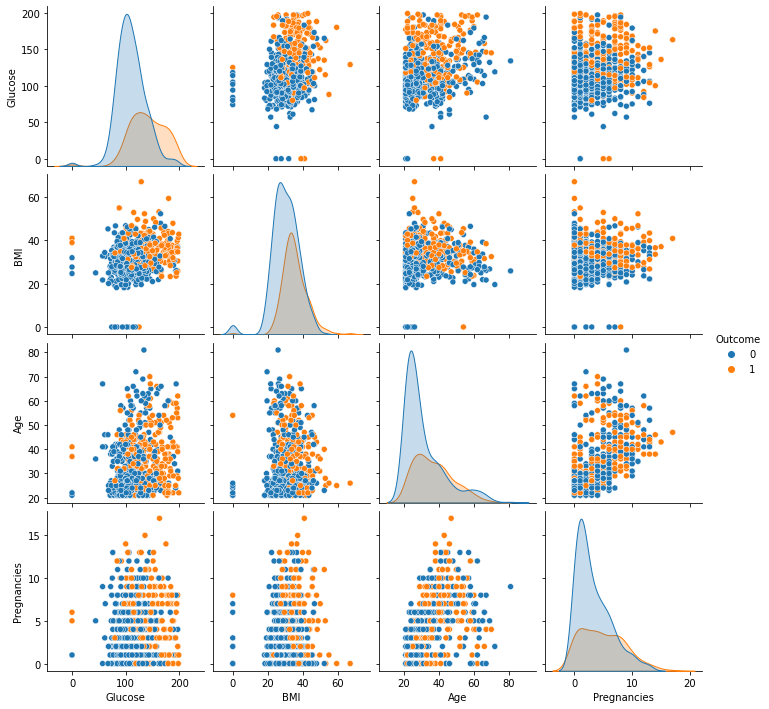

In [83]:
sns.pairplot(df_cut, hue = 'Outcome')

По этим графикам видно, что у здоровых женщин размах значений всех 4х признаков существенно больше. Синим обозначены женщины без диабета, оранжевым - с диабетом.

**И дальше перехожу к обучению модели "Дерево решений".**

Её цель: предсказать наличие диабета, опираясь на данные 4х признаков.

In [84]:
#запускаю дерево решений
model = tree.DecisionTreeClassifier() #при желании можно ограничить глубину ветвления max_depth = 4
model.fit(df_cut[['Glucose', 'BMI', 'Age', 'Pregnancies']].values.reshape(-1,4),   #нецелевые признаки
          y = df_cut['Outcome'].values)                                            #целевой признак

DecisionTreeClassifier()

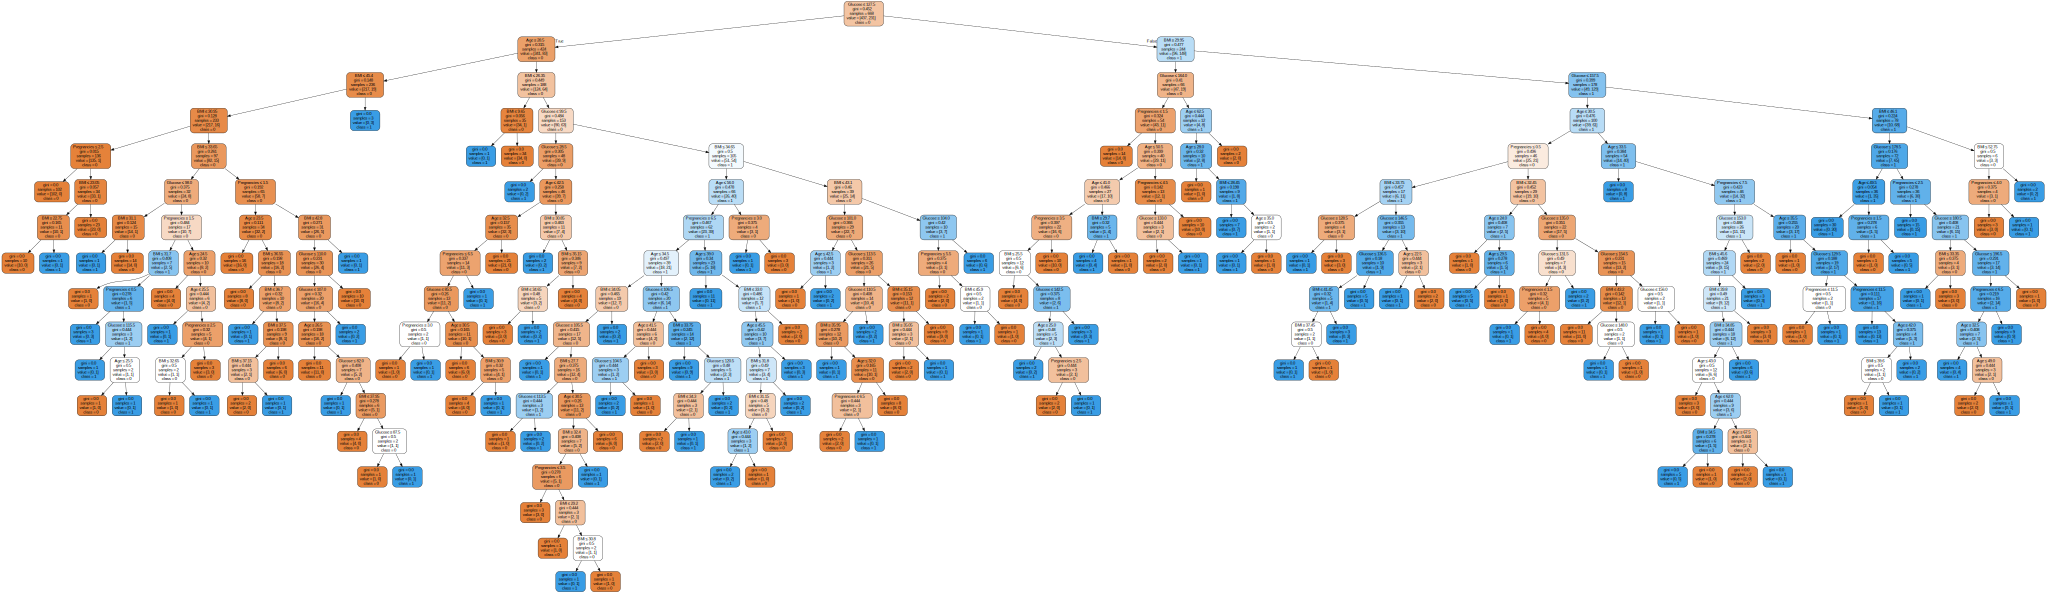

In [85]:
#визуализирую дерево решений
import graphviz
dot_data = tree.export_graphviz(model, out_file = None,
                                feature_names = ['Glucose', 'BMI', 'Age', 'Pregnancies'],
                                class_names = ['0', '1'],
                                filled = True,
                                rounded = True,
                                special_characters = True)
graph = graphviz.Source(dot_data)
graph

**Загружаю тестовую выборку:**

In [86]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_test.csv', sep = ',')
df_test_cut = df_test[['Glucose', 'BMI', 'Age', 'Pregnancies', 'Outcome']]
df_test_cut = df_test_cut.dropna()
df_test_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Glucose      100 non-null    int64  
 1   BMI          100 non-null    float64
 2   Age          100 non-null    int64  
 3   Pregnancies  100 non-null    int64  
 4   Outcome      100 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 4.7 KB


In [87]:
#через функцию predict прогоняю объекты тестовой выборки 
df_test_cut['Predicted'] = model.predict(df_test_cut[['Glucose', 'BMI', 'Age', 'Pregnancies']].values.reshape(-1,4))

In [88]:
#строю матрицу сопряженностей (матрицу ошибок)
pd.crosstab(df_test_cut['Predicted'], df_test_cut['Outcome'])

Outcome,0,1
Predicted,,
0,49,16
1,14,21


**70 человек из 100 были классифицированы верно (49 здоровых и 21 диабет-положительный),** т.е. точность этой модели **70%.\**

Важное замечание: для деревьев НЕ нужно нормировать данные.

**Метрики качества**

Есть два показателя: precision и recall. Их можно подсчитать для каждого класса.

**precision(для диабетиков) = доля истинных диабетиков среди людей, отнесенных ИИ к диабетикам**
*   precision(для диабетиков) = 21 / (21 + 14) = 0,6
*   precision(для здоровых) = 49 / (49 + 16) = 0,753846

**recall(для диабетиков) = доля правильно предсказанных диабетиков среди всех диабетиков.**
*   recall(для диабетиков) = 21 / (21 + 16) = 0,567568
*   recall(для здоровых) = 49 / (49 + 14) = 0,7777778

В идеале нужно стремиться, чтоб и precision и recall были равны единице.


In [89]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df_test_cut['Outcome'], df_test_cut['Predicted'])
#precision для здоровых, больных
#recall для здоровых, больных
#f1-метрика
#число всех здоровых, число всех больных (реально)

(array([0.75384615, 0.6       ]),
 array([0.77777778, 0.56756757]),
 array([0.765625  , 0.58333333]),
 array([63, 37]))

Запихиваю эти расчеты в понятную таблицу:

In [90]:
my_metrics = precision_recall_fscore_support(df_test_cut['Outcome'], df_test_cut['Predicted'])
metrics_in_table = pd.DataFrame(my_metrics,   #создаю датафрейм и закидываю в него полученные числа
                              index = [['precision', 'recall', 'fscore', 'всего в выборке']],            #в качестве индексов назначаю названия признаков
                              columns = ['0 (нет диабета)', '1 (есть диабет)'])      #задаю имя единственному столбцу нового датафрейма 
metrics_in_table

,0 (нет диабета),1 (есть диабет)
precision,0.753846,0.600000
recall,0.777778,0.567568
fscore,0.765625,0.583333
всего в выборке,63.000000,37.000000


In [91]:
df_test_cut['Code'] = '0'  #диагноз верный
df_test_cut.loc[(df_test_cut['Outcome'] == 0) & (df_test_cut['Predicted'] == 1), 'Code'] = '1'   #ложноположительный диагноз
df_test_cut.loc[(df_test_cut['Outcome'] == 1) & (df_test_cut['Predicted'] == 0), 'Code'] = '2'   #ложноотрицательный диагноз

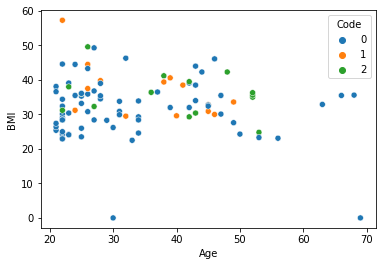

In [92]:
sns.scatterplot(data = df_test_cut,
                x = 'Age',
                y = 'BMI',
                hue = 'Code')

Визуализация полученного результата. Синие точки - женщины с верным диагнозом, оранжевые - с ложноотрицательным, зеленые - с ложноположительным.

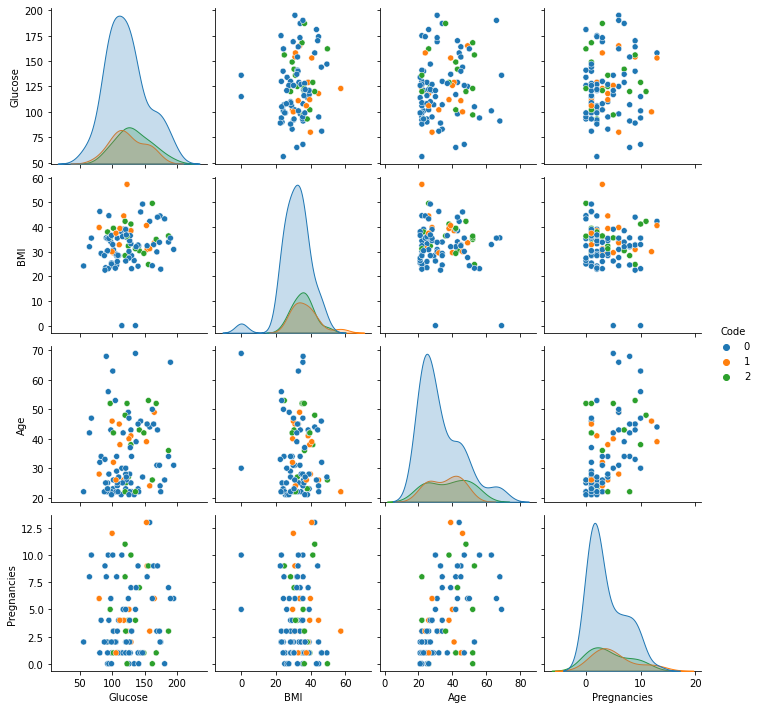

In [93]:
sns.pairplot(df_test_cut[['Glucose', 'BMI', 'Age', 'Pregnancies', 'Code']], hue = 'Code')

А на этой группе графиков я хотела посмотреть распределение неверно предсказанных диагнозов в зависимости от выбранных осей. Но какой-то явной тенденции нет. Ошибки разбросаны довольно хаотично.